# Option Pricing: Black-Scholes, Heston, and Merton
## Objective: Understand and compare three fundamental option pricing models.

- **Black-Scholes:** The benchmark model assuming constant volatility.  
Great baseline, fast, but assumes constant vol (unrealistic).
    
- **Heston:** Adds stochastic volatility (volatility clustering and mean reversion).  
Captures the "Smirk" or "Skew" via stochastic vol. Essential for pricing OTM puts accurately.
    
- **Merton Jump:** Adds "jumps" to the asset price to model market shocks.  
Captures "Fat Tails" and sudden crashes via Poisson jumps.

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy.integrate import quad
import seaborn as sns

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Global Parameters (Toggles)
S0 = 100.0    # Spot Price
K_list = np.linspace(80, 120, 50) # Range of Strikes for plotting
T = 1.0       # Time to Maturity (1 year)
r = 0.05      # Risk-free rate
q = 0.0       # Dividend yield

## Black-Scholes Model

The Black-Scholes model assumes the stock price $S_t$ follows a Geometric Brownian Motion (GBM):$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

Where:   
- $\mu$ is the drift.  
- $\sigma$ is the constant volatility.  
- $dW_t$ is a Wiener process (Brownian motion). 
<br>

**Call Option Formula**  
The price of a European Call option $C(S, t)$ is given by:  
$$C(S, t) = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)$$
<br>
Where $N(\cdot)$ is the cumulative distribution function of the standard normal distribution, and:  
$$d_1 = \frac{\ln(S_0/K) + (r - q + \sigma^2/2)T}{\sigma\sqrt{T}}$$$$d_2 = d_1 - \sigma\sqrt{T}$$

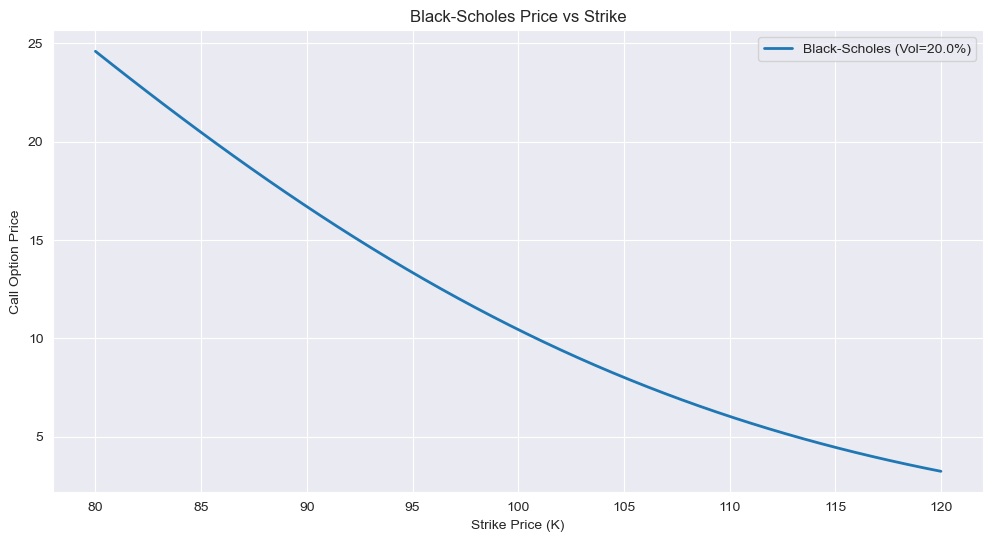

In [4]:
def black_scholes_model(S, K, T, r, q, sigma):
    """
    Calculates the Black-Scholes European Call Price.
    """
    # Safety check for sigma
    if sigma <= 0: return max(S*np.exp(-q*T) - K*np.exp(-r*T), 0)
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - 
                  K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call_price

# --- Example Usage ---
sigma_bs = 0.2
bs_prices = [black_scholes_model(S0, k, T, r, q, sigma_bs) for k in K_list]

plt.plot(K_list, bs_prices, label=f'Black-Scholes (Vol={sigma_bs*100}%)', linewidth=2)
plt.xlabel("Strike Price (K)")
plt.ylabel("Call Option Price")
plt.title("Black-Scholes Price vs Strike")
plt.legend()
plt.show()


## 2. The Heston Model (Stochastic Volatility)

Black-Scholes fails to capture the "volatility smile" observed in real markets. Heston solves this by modeling variance $v_t$ as a stochastic process itself.

### The Dynamics (SDEs)

The Heston model uses two coupled Stochastic Differential Equations (SDEs):

1. **Asset Process:**
    
    $$dS_t = \mu S_t dt + \sqrt{v_t} S_t dW_t^S$$
    
2. **Variance Process (CIR Process):**
    
    $$dv_t = \kappa (\theta - v_t) dt + \xi \sqrt{v_t} dW_t^v$$

**Parameters:**

- $v_0$: Initial variance.
    
- $\kappa$: Mean reversion speed (how fast vol returns to average).
    
- $\theta$: Long-run average variance.
    
- $\xi$: "Vol of Vol" (volatility of the variance).
    
- $\rho$: Correlation between asset returns and variance shocks ($dW_t^S$ and $dW_t^v$). usually $\rho < 0$.

<br>

### Pricing via Characteristic Functions

Since there is no simple closed-form solution like Black-Scholes, we use the Fourier Transform method. The price is an integral of the Characteristic Function $\phi$.

**Important Note on Stability (Albrecher et al.):**

Standard implementations of the Heston characteristic function often suffer from "branch cut" discontinuities, leading to numerical explosions (sawtooth graphs). We use the "Albrecher" representation to ensure the characteristic function remains continuous and stable.

In [5]:
def heston_characteristic_function(u, S0, K, T, r, q, v0, kappa, theta, xi, rho):
    """
    Returns the Heston Characteristic Function (Albrecher/Stable form).
    u: Argument of the characteristic function (complex)
    """
    # 1. Setup intermediate variables
    # Note: Albrecher form uses 'd' and 'g' to avoid branch cuts
    
    # Complex number i
    i = 1j 
    
    # Product of rho * xi * i * u
    rsiu = rho * xi * i * u 
    
    # d variable
    d = np.sqrt((rho * xi * i * u - kappa)**2 + (xi**2) * (i * u + u**2))
    
    # g variable (the "stable" calculation)
    # Standard form uses (kappa - rsiu - d) / (kappa - rsiu + d) which is unstable
    g = (kappa - rsiu - d) / (kappa - rsiu + d)
    
    # 2. Calculate the characteristic function parts
    # A(u) part
    term1 = (kappa * theta) / (xi**2) * ((kappa - rsiu - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    
    # B(u) part
    term2 = (v0 / (xi**2)) * (kappa - rsiu - d) * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
    
    # Final exp
    return np.exp(i * u * np.log(S0) + i * u * (r - q) * T + term1 + term2)

def heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho):
    """
    Calculates Heston Call Price using Fourier Transform integration.
    """
    
    # Integrand for P1 (Delta-like term)
    def integrand1(u):
        cf = heston_characteristic_function(u - 1j, S0, K, T, r, q, v0, kappa, theta, xi, rho)
        num = np.exp(-1j * u * np.log(K)) * cf
        den = (1j * u * S0 * np.exp((r-q)*T))
        return (num / den).real

    # Integrand for P2 (Risk-neutral probability)
    def integrand2(u):
        cf = heston_characteristic_function(u, S0, K, T, r, q, v0, kappa, theta, xi, rho)
        num = np.exp(-1j * u * np.log(K)) * cf
        den = (1j * u)
        return (num / den).real

    # Integration limits (0 to infinity)
    limit_max = 100 # usually sufficient, can increase if issues arise
    
    P1 = 0.5 + (1 / np.pi) * quad(integrand1, 0, limit_max)[0]
    P2 = 0.5 + (1 / np.pi) * quad(integrand2, 0, limit_max)[0]
    
    call_price = S0 * np.exp(-q * T) * P1 - K * np.exp(-r * T) * P2
    return call_price

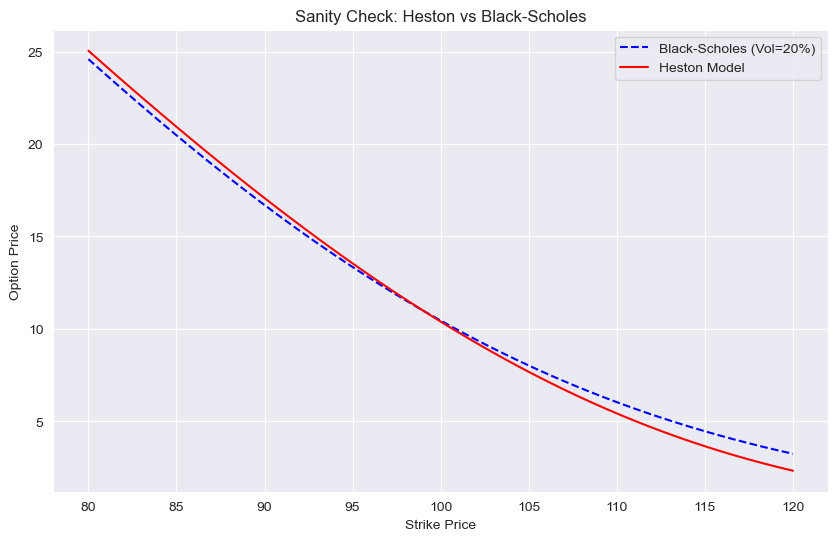

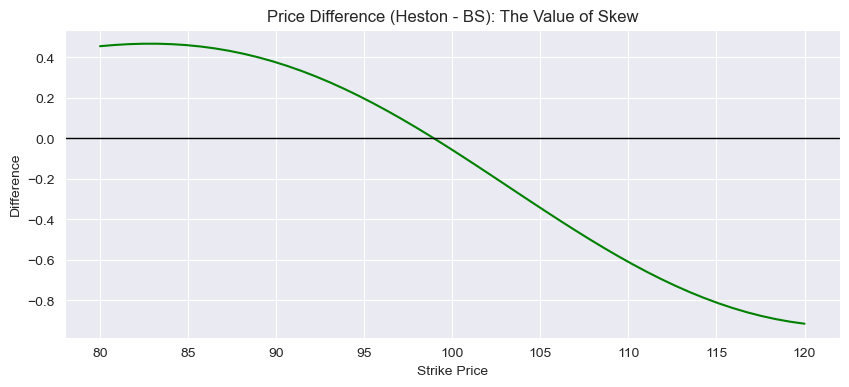

In [6]:
# Heston Parameters
v0 = 0.04    # Current Variance (equiv to 20% vol)
kappa = 2.0  # Mean reversion speed
theta = 0.04 # Long run average variance
xi = 0.3     # Vol of Vol
rho = -0.7   # Correlation

# Calculate Prices
heston_prices = [heston_call_price(S0, k, T, r, q, v0, kappa, theta, xi, rho) for k in K_list]
bs_prices = [black_scholes_call(S0, k, T, r, q, np.sqrt(v0)) for k in K_list]

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(K_list, bs_prices, 'b--', label='Black-Scholes (Vol=20%)')
plt.plot(K_list, heston_prices, 'r-', label='Heston Model')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Sanity Check: Heston vs Black-Scholes')
plt.legend()

# Difference Plot (to see the "Smile" effect implicitly)
plt.figure(figsize=(10, 4))
plt.plot(K_list, np.array(heston_prices) - np.array(bs_prices), 'g-')
plt.axhline(0, color='black', lw=1)
plt.title('Price Difference (Heston - BS): The Value of Skew')
plt.xlabel('Strike Price')
plt.ylabel('Difference')
plt.show()

## 3. Merton Jump Diffusion (MJD)

Markets sometimes crash. Black-Scholes and Heston (mostly) assume continuous paths. Merton adds a "Jump" component.

### The Dynamics (SDE)

$$dS_t = (\mu - \lambda k) S_t dt + \sigma S_t dW_t + S_t (Y - 1) dN_t$$

Where:

- $dN_t$: Poisson process (Jump counter) with intensity $\lambda$ (avg jumps per year).
    
- $Y$: Jump size, log-normally distributed $\ln(Y) \sim N(\mu_J, \delta^2)$.
    
- $k$: Expected jump size $E[Y-1] = e^{\mu_J + \delta^2/2} - 1$.
    

### Simulation Approach

While closed-form solutions exist (infinite series of BS prices), Monte Carlo is excellent for intuition here to _see_ the jumps.

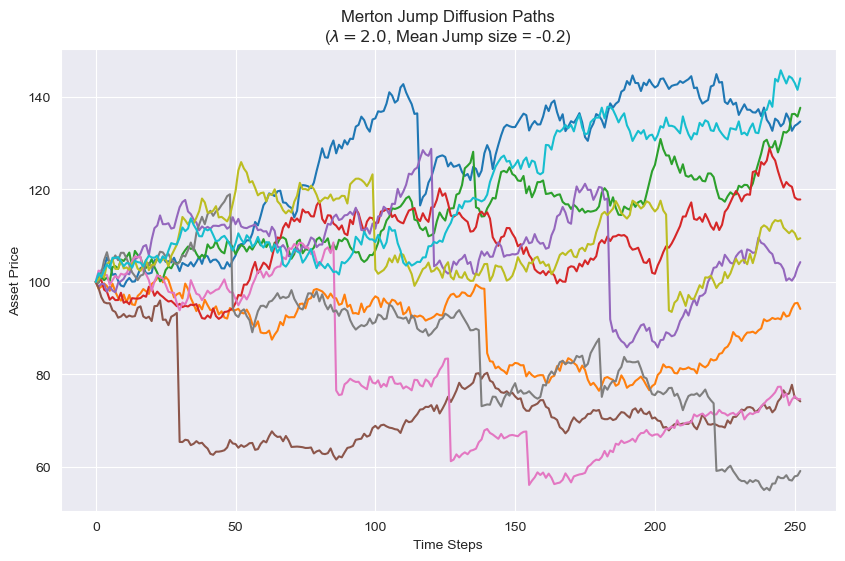

In [7]:
def merton_jump_paths(S0, T, r, sigma, lam, mu_j, delta, n_steps=252, n_paths=10):
    """
    Simulates paths for Merton Jump Diffusion.
    """
    dt = T / n_steps
    
    # 1. Brownian Motion part (Standard BS)
    # Z ~ N(0, 1)
    Z = np.random.normal(0, 1, size=(n_steps, n_paths))
    
    # 2. Poisson Jump part
    # J ~ Poisson(lam * dt) -> Number of jumps in this step
    J = np.random.poisson(lam * dt, size=(n_steps, n_paths))
    
    # 3. Jump Magnitude
    # If J=1, we add a normal shock N(mu_j, delta)
    # We sum up shocks if multiple jumps occur in one dt (rare but possible)
    mean_jump = np.exp(mu_j + 0.5 * delta**2) - 1
    drift_correction = lam * mean_jump
    
    # Create path array
    S = np.zeros((n_steps + 1, n_paths))
    S[0] = S0
    
    for t in range(1, n_steps + 1):
        # Continuous return
        continuous_log_ret = (r - drift_correction - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1]
        
        # Jump return
        # Calculate sum of log-normal jumps for this step
        # Jump size Y is log-normal, so log(Y) is normal
        jump_log_ret = np.random.normal(mu_j, delta, size=(n_paths)) * J[t-1]
        
        S[t] = S[t-1] * np.exp(continuous_log_ret + jump_log_ret)
        
    return S

# Parameters for Jumps
lam = 2.0      # Expect 2 jumps per year
mu_j = -0.2    # Average jump is -20% (Downside shock)
delta = 0.1    # Volatility of the jump size
sigma_m = 0.2  # Diffusion volatility

paths = merton_jump_paths(S0, T, r, sigma_m, lam, mu_j, delta, n_paths=10)

plt.figure(figsize=(10, 6))
plt.plot(paths)
plt.title(f"Merton Jump Diffusion Paths\n($\lambda={lam}$, Mean Jump size = {mu_j})")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.show()

## Heston Greeks (Finite Differences)

Since Heston derivatives are complex to derive analytically, we use **Finite Differences**. This approximates the slope of the pricing surface by nudging the inputs slightly.

We use **Central Difference** for better accuracy:

$$\Delta \approx \frac{P(S + \epsilon) - P(S - \epsilon)}{2\epsilon}$$

$$\Gamma \approx \frac{P(S + \epsilon) - 2P(S) + P(S - \epsilon)}{\epsilon^2}$$

- **Delta ($\Delta$):** Sensitivity to Spot Price.
    
- **Gamma ($\Gamma$):** Sensitivity to Delta (curvature).
    
- **Vega ($\nu$):** Sensitivity to Volatility (in Heston, sensitivity to initial variance $v_0$).
    
- **Theta ($\Theta$):** Sensitivity to Time Decay.
    

In [8]:
def heston_greeks(S0, K, T, r, q, v0, kappa, theta, xi, rho):
    """
    Calculates Heston Greeks using Central Finite Differences.
    Returns a dictionary of Greeks.
    """
    # Perturbations
    dS = S0 * 0.01  # 1% spot shift
    dv = v0 * 0.01  # 1% variance shift
    dt = 1 / 365    # 1 day shift
    
    # Base Price (Center)
    p_base = heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho)
    
    # --- Delta & Gamma (Shock Spot) ---
    p_up = heston_call_price(S0 + dS, K, T, r, q, v0, kappa, theta, xi, rho)
    p_down = heston_call_price(S0 - dS, K, T, r, q, v0, kappa, theta, xi, rho)
    
    delta = (p_up - p_down) / (2 * dS)
    gamma = (p_up - 2 * p_base + p_down) / (dS ** 2)
    
    # --- Vega (Shock Initial Variance v0) ---
    # Note: Vega in Heston is dP/d(sqrt(v0)) usually, but here we do dP/dv0 for strictly variance sensitivity
    # To make it comparable to BS Vega, we often normalize or just track dP/dv0
    p_v_up = heston_call_price(S0, K, T, r, q, v0 + dv, kappa, theta, xi, rho)
    p_v_down = heston_call_price(S0, K, T, r, q, v0 - dv, kappa, theta, xi, rho)
    vega = (p_v_up - p_v_down) / (2 * dv) 
    
    # --- Theta (Shock Time) ---
    # Theta is usually negative (decay), so we look at Price(T - dt) - Price(T)
    # But for the formula T is "time to maturity", so as time passes, T decreases.
    p_t_minus = heston_call_price(S0, K, T - dt, r, q, v0, kappa, theta, xi, rho)
    theta_val = (p_t_minus - p_base) / dt 
    
    return {
        "Price": p_base,
        "Delta": delta,
        "Gamma": gamma,
        "Vega_v0": vega,
        "Theta": theta_val
    }

# --- Test the Greeks ---
greeks = heston_greeks(S0=100, K=100, T=1.0, r=0.05, q=0.0, v0=0.04, 
                       kappa=2.0, theta=0.04, xi=0.3, rho=-0.7)

print(f"Heston ATM Call Greeks:\n{pd.Series(greeks)}")

Heston ATM Call Greeks:
Price      10.394219
Delta       0.691721
Gamma       0.017411
Vega_v0    39.213117
Theta      -6.451315
dtype: float64


## Model Calibration (Fitting to the Smile)

Calibration is the reverse of pricing.

- **Pricing:** Parameters $\rightarrow$ Price.
    
- **Calibration:** Market Prices $\rightarrow$ Parameters.
    

We use **Least Squares Optimization**. We search for the set of parameters $\Theta = \{v_0, \kappa, \theta, \xi, \rho\}$ that minimizes the difference between our model prices and market prices.

$$\min_{\Theta} \sum_{i=1}^{N} (C_{model}(K_i, T_i) - C_{market}(K_i, T_i))^2$$

The diagram below shows what we are trying to fit: the **Volatility Smile**. If Heston is working, it should capture the "skew" (higher prices for low-strike puts) better than Black-Scholes.

Calibration Success: True
------------------------------
Parameter  | True       | Calibrated
------------------------------
v0         | 0.0500     | 0.0470    
kappa      | 1.5000     | 0.9296    
theta      | 0.0500     | 0.0547    
xi         | 0.4000     | 0.3189    
rho        | -0.6000    | -0.6061   


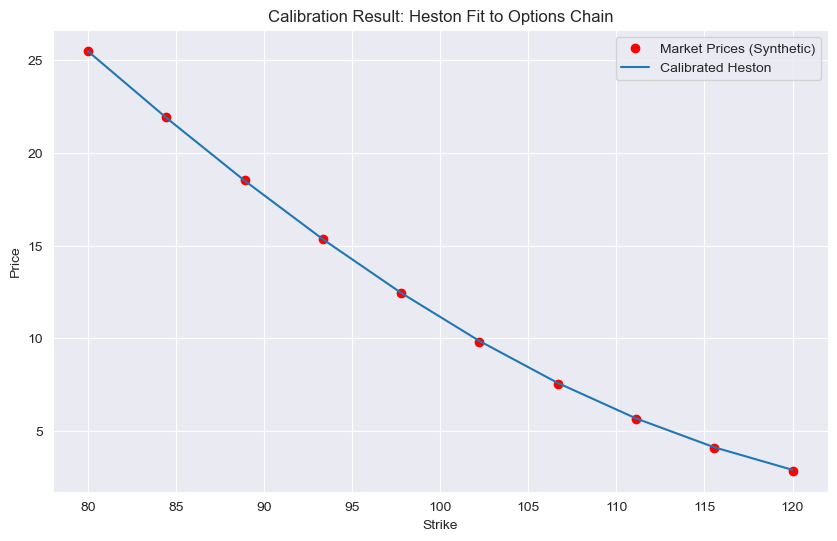

In [9]:
from scipy.optimize import minimize

def calibration_objective(params, market_prices, strikes, S0, T, r, q):
    """
    Objective function for the optimizer. 
    Calculates Sum of Squared Errors (SSE) between Heston and Market prices.
    """
    v0, kappa, theta, xi, rho = params
    
    # Penalties for violation of constraints (Soft constraints)
    # Feller condition: 2*kappa*theta > xi**2 (ensures variance > 0)
    penalty = 0
    if 2*kappa*theta <= xi**2:
        penalty += 100 # Add a large penalty error
        
    error = 0.0
    for i, K in enumerate(strikes):
        model_price = heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho)
        market_price = market_prices[i]
        error += (model_price - market_price)**2
        
    return error + penalty

# --- 1. Generate "Synthetic" Market Data ---
# (Since we don't have WRDS data loaded yet, we fake it using known parameters)
true_params = [0.05, 1.5, 0.05, 0.4, -0.6] # v0, kappa, theta, xi, rho
market_strikes = np.linspace(80, 120, 10)
market_prices = [heston_call_price(S0, k, T, r, q, *true_params) for k in market_strikes]

# --- 2. Run Calibration ---
# Initial Guesses (random start)
initial_guess = [0.04, 1.0, 0.04, 0.2, -0.5] 

# Bounds: ((v0), (kappa), (theta), (xi), (rho))
# v0, kappa, theta, xi > 0; -1 < rho < 1
bnds = ((0.001, 0.5), (0.01, 5.0), (0.001, 0.5), (0.01, 1.0), (-0.99, 0.99))

result = minimize(calibration_objective, initial_guess, 
                  args=(market_prices, market_strikes, S0, T, r, q),
                  method='SLSQP', bounds=bnds)

# --- 3. Report Results ---
print("Calibration Success:", result.success)
print("-" * 30)
print(f"{'Parameter':<10} | {'True':<10} | {'Calibrated':<10}")
print("-" * 30)
names = ['v0', 'kappa', 'theta', 'xi', 'rho']
for name, tr, cal in zip(names, true_params, result.x):
    print(f"{name:<10} | {tr:<10.4f} | {cal:<10.4f}")

# Plot Fit
calibrated_prices = [heston_call_price(S0, k, T, r, q, *result.x) for k in market_strikes]
plt.figure(figsize=(10, 6))
plt.scatter(market_strikes, market_prices, c='red', label='Market Prices (Synthetic)')
plt.plot(market_strikes, calibrated_prices, label='Calibrated Heston')
plt.title("Calibration Result: Heston Fit to Options Chain")
plt.xlabel("Strike")
plt.ylabel("Price")
plt.legend()
plt.show()